Please upload evaluation file. This version of data analysis is taking feedback to "male-associated" eassys v.s. their counterfactual versions (by replacing male associated words with their female synonymous words) as materials and shows the results.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving cosine similarity calculationM vs M-F.xlsx to cosine similarity calculationM vs M-F.xlsx


# **1.Analysis of open ended feedback text.**
### **1.1 similarity calculation (Cosine Similarity and Euclidean Distance)**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 7.8 MB/s eta 0:00:00


Embedding B: 100%|██████████| 299/299 [01:32<00:00,  3.24it/s]


embeddings_a shape: (299, 3072)
embeddings_b shape: (299, 3072)

=== Descriptive Statistics ===
       cosine_similarity  euclidean_distance
count         299.000000          299.000000
mean            0.883465            0.478646
std             0.030606            0.063102
min             0.782262            0.273686
25%             0.865901            0.434382
50%             0.887185            0.475006
75%             0.905656            0.517879
max             0.962548            0.659906


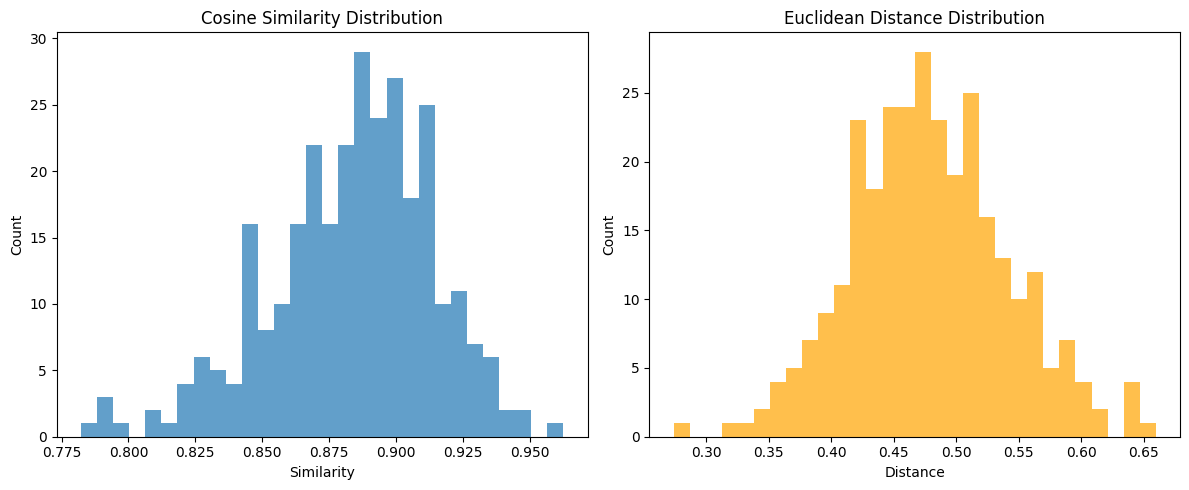


Running Cosine Similarity Analysis...


Permutations: 100%|██████████| 5000/5000 [11:42<00:00,  7.12it/s]



=== Permutation Test Results ===
Metric: cosine
Observed Statistic: 0.1876
Permutation Mean: 0.1801
p-value (two-tailed): 0.0000
Effect Size (Corrected Z): 0.1265
Cohen's d (between vs within): 0.2686


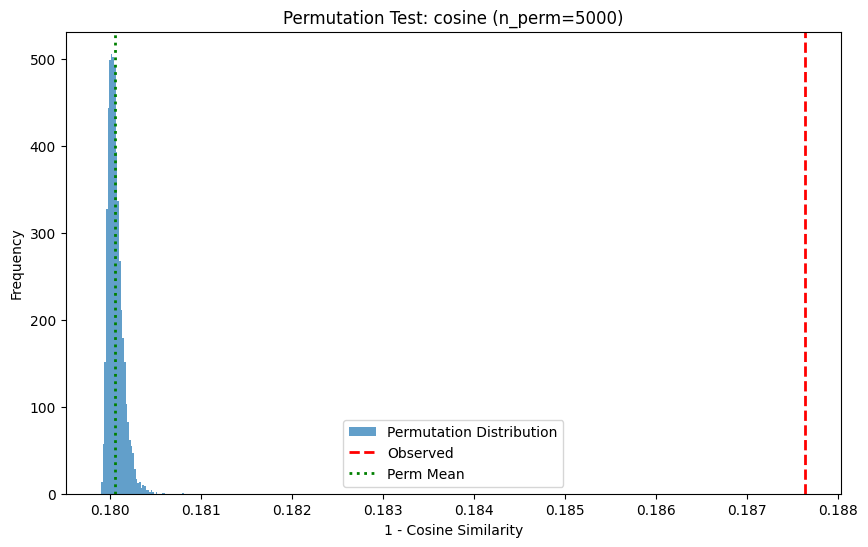


Running Euclidean Distance Analysis...


Permutations: 100%|██████████| 5000/5000 [08:23<00:00,  9.93it/s]



=== Permutation Test Results ===
Metric: euclidean
Observed Statistic: 0.6052
Permutation Mean: 0.5911
p-value (two-tailed): 0.0000
Effect Size (Corrected Z): 0.1494
Cohen's d (between vs within): 0.3163


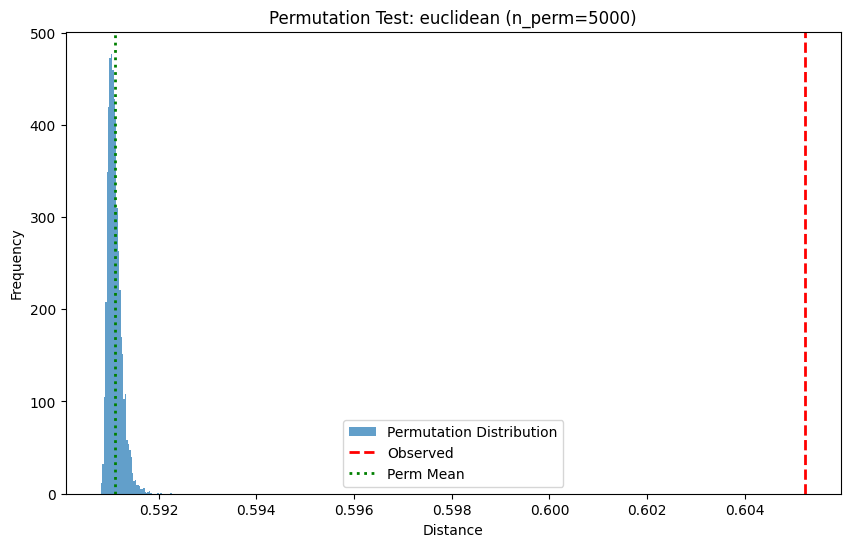

In [2]:
# Install necessary packages
!pip install openai pandas scipy numpy openpyxl tqdm matplotlib pingouin

# Import required libraries
import openai
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from tqdm import tqdm
import matplotlib.pyplot as plt
from getpass import getpass
import pingouin as pg


# Set OpenAI API Key
openai_api_key = getpass("🔐 Enter your OpenAI API Key: ")

# Function to retrieve text embeddings
def get_embedding(text, model="text-embedding-3-large"):
    response = openai.embeddings.create(
        input=text,
        model=model,
        encoding_format="float"
    )
    return np.array(response.data[0].embedding)


# Load Excel file (assumes feedback for original and counterfactual essays are in the first and second columns)
excel_path = list(uploaded.keys())[0]
df = pd.read_excel(excel_path)

# Extract text columns
texts_a = df.iloc[:, 0].astype(str).tolist()
texts_b = df.iloc[:, 1].astype(str).tolist()

# Generate embeddings
embeddings_a = np.array([get_embedding(text) for text in tqdm(texts_a, desc="Embedding A")])
embeddings_b = np.array([get_embedding(text) for text in tqdm(texts_b, desc="Embedding B")])

# Check the shape of the embedding matrices
print(f"embeddings_a shape: {embeddings_a.shape}")  # Expected shape: (n_samples, embedding_dim)
print(f"embeddings_b shape: {embeddings_b.shape}")


# Compute pairwise similarity metrics
def assess_similarity(matrix1, matrix2):
    """
    Compute cosine similarity and Euclidean distance between aligned vectors.
    Returns a DataFrame of results.
    """
    cosine_sim = np.array([np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
                          for v1, v2 in zip(matrix1, matrix2)])

    euclidean_dist = np.linalg.norm(matrix1 - matrix2, axis=1)

    results = pd.DataFrame({
        'cosine_similarity': cosine_sim,
        'euclidean_distance': euclidean_dist
    })
    return results


# Permutation testing and effect size calculation
def permutation_test(matrix1, matrix2, n_permutations=5000, metric='cosine', seed=42):
    np.random.seed(seed)
    combined = np.vstack((matrix1, matrix2))
    n = len(matrix1)

    # Observed test statistic
    obs_stat = np.mean(cdist(matrix1, matrix2, metric=metric))

    # Permutation test
    perm_stats = []
    for _ in tqdm(range(n_permutations), desc="Permutations"):
        np.random.shuffle(combined)
        perm_group1 = combined[:n]
        perm_group2 = combined[n:]
        perm_stat = np.mean(cdist(perm_group1, perm_group2, metric=metric))
        perm_stats.append(perm_stat)

    perm_stats = np.array(perm_stats)

    # Two-tailed p-value
    p_value = np.mean(np.abs(perm_stats - np.mean(perm_stats)) >= np.abs(obs_stat - np.mean(perm_stats)))

    # Corrected effect size: avoid inflated values from low permutation variance
    pooled_std = np.std(cdist(matrix1, matrix2, metric=metric))
    effect_size_perm = (obs_stat - np.mean(perm_stats)) / pooled_std

    # Additional effect size: Cohen's d
    if metric == 'cosine':
        # Convert similarity to distance for directional consistency with Euclidean
        all_dists = 1 - np.array([np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
                         for v1 in matrix1 for v2 in matrix2])
        within_dists = 1 - np.array([np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
                           for v1 in matrix1 for v2 in matrix1])
    else:
        all_dists = cdist(matrix1, matrix2, metric=metric).flatten()
        within_dists = cdist(matrix1, matrix1, metric=metric).flatten()

    cohen_d = pg.compute_effsize(all_dists, within_dists, eftype='cohen')

    # Output results
    print("\n=== Permutation Test Results ===")
    print(f"Metric: {metric}")
    print(f"Observed Statistic: {obs_stat:.4f}")
    print(f"Permutation Mean: {np.mean(perm_stats):.4f}")
    print(f"p-value (two-tailed): {p_value:.4f}")
    print(f"Effect Size (Corrected Z): {effect_size_perm:.4f}")
    print(f"Cohen's d (between vs within): {cohen_d:.4f}")

    # Plot permutation distribution
    plt.figure(figsize=(10, 6))
    plt.hist(perm_stats, bins=50, alpha=0.7, label='Permutation Distribution')
    plt.axvline(obs_stat, color='red', linestyle='--', linewidth=2, label='Observed')
    plt.axvline(np.mean(perm_stats), color='green', linestyle=':', linewidth=2, label='Perm Mean')
    plt.legend()
    plt.title(f"Permutation Test: {metric} (n_perm={n_permutations})")
    plt.xlabel("Distance" if metric != 'cosine' else "1 - Cosine Similarity")
    plt.ylabel("Frequency")
    plt.show()

    return {
        'observed_stat': obs_stat,
        'p_value': p_value,
        'effect_size_perm': effect_size_perm,
        'cohen_d': cohen_d
    }


# Main analysis pipeline
if __name__ == "__main__":
    # 1. Compute descriptive similarity metrics
    similarity_results = assess_similarity(embeddings_a, embeddings_b)
    print("\n=== Descriptive Statistics ===")
    print(similarity_results.describe())

    # 2. Plot similarity and distance distributions
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(similarity_results['cosine_similarity'], bins=30, alpha=0.7)
    plt.title("Cosine Similarity Distribution")
    plt.xlabel("Similarity")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    plt.hist(similarity_results['euclidean_distance'], bins=30, alpha=0.7, color='orange')
    plt.title("Euclidean Distance Distribution")
    plt.xlabel("Distance")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # 3. Run permutation test on cosine similarity
    print("\nRunning Cosine Similarity Analysis...")
    cos_result = permutation_test(embeddings_a, embeddings_b, metric='cosine')

    # 4. Run permutation test on Euclidean distance
    print("\nRunning Euclidean Distance Analysis...")
    euc_result = permutation_test(embeddings_a, embeddings_b, metric='euclidean')

**Notes on Statistical Methodology**

1.Effect Size

In initial analyses, the observed cosine similarity (mean = 0.1876) showed a marginal deviation from the permutation mean (0.1800). When using the standard deviation of the permutation distribution as the denominator, this small absolute difference yielded an inflated effect size (>90), indicating oversensitivity to minimal fluctuations in the null distribution.  

To address this, this analysis substituted the denominator with the pooled standard deviation of the empirical (non-permuted) distances:  

`pooled_std = np.std(cdist(matrix1, matrix2, metric=metric))`

This correction yields a stabilized permutation Z-score that better reflects the true effect magnitude. Cohen's d is reported as a complementary reference metric for effect size interpretation.


2.Direction Consistency in Metrics

Since cosine similarity increases with semantic similarity (higher = more similar), while Euclidean distance decreases (lower = more similar), I convert cosine similarity to a distance-like metric:

`distance = 1 - cosine_similarity`

to ensure interpretative consistency across metrics (i.e., lower values always indicate more similarity).



3.Permutation Testing

A two-tailed p-value is computed in this analysis, comparing the observed statistic to the full permutation distribution.

This nonparametric test avoids assumptions about normality and enables robust inference from embedding distances.

### **1.2 Visualization through dimensionality reduction**
The implementation includes:


PCA Analysis: Evaluates global structure preservation through explained variance and reconstruction error, identifying dominant directions of variation in the embedding space.

t-SNE Projection: Assesses local neighborhood preservation using trustworthiness and k-NN preservation metrics, particularly valuable for identifying cluster separation and local structure.

UMAP Visualization: Offers an alternative nonlinear projection with quantitative evaluation of local structure maintenance through k-NN preservation rates.

Dot Product Analysis: Provides direct measurement of semantic alignment between
paired embeddings, with statistical characterization of similarity distribution.

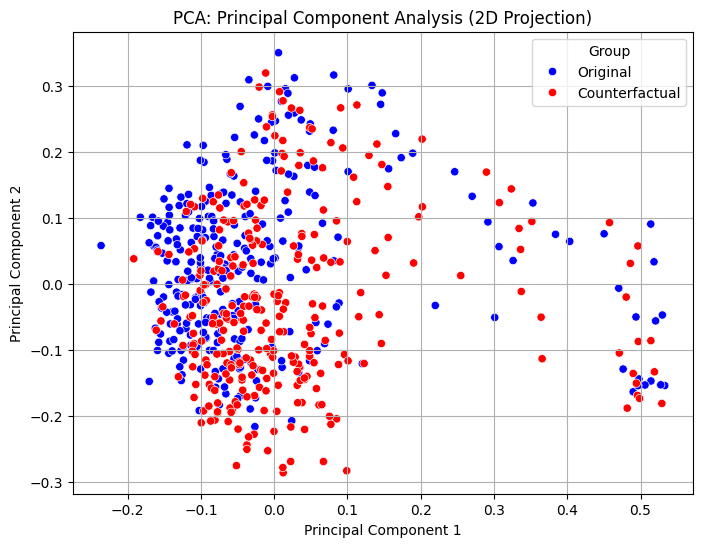

PCA Diagnostic Metrics:
- Eigenvalues: [0.02244456 0.01702797]
- Explained Variance Ratio: [0.12465145 0.09456907]
- Cumulative Explained Variance: 0.2192
- Reconstruction MSE: 0.0000
Statistical Interpretation:
    Eigenvalues indicate the magnitude of variance captured by each principal component.
    Explained variance ratios show the proportion of total variance accounted for by each component.
    Reconstruction error measures information loss during dimensionality reduction.



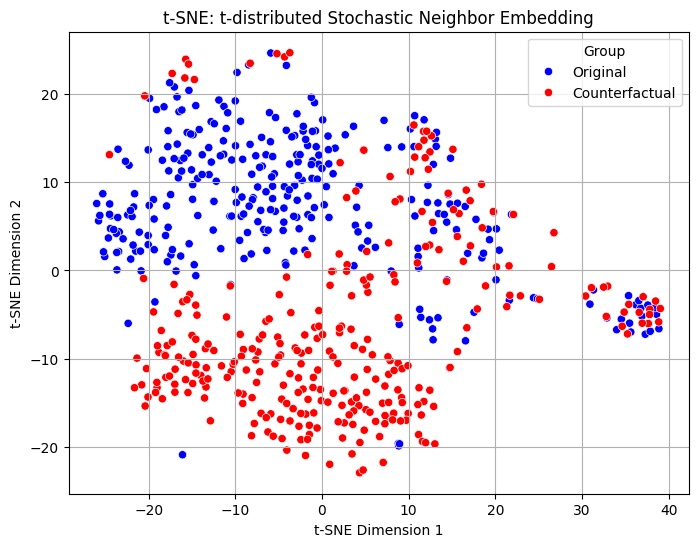

t-SNE Quality Metrics:
- KL Divergence: 1.1120
- Trustworthiness: 0.9567
- k-NN Preservation Rate: 0.4575
Statistical Interpretation:
    KL divergence quantifies the difference between high-dimensional and low-dimensional distributions.
    Trustworthiness measures the preservation of neighborhood relationships (higher is better).
    k-NN preservation rate indicates local structure maintenance during dimensionality reduction.



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


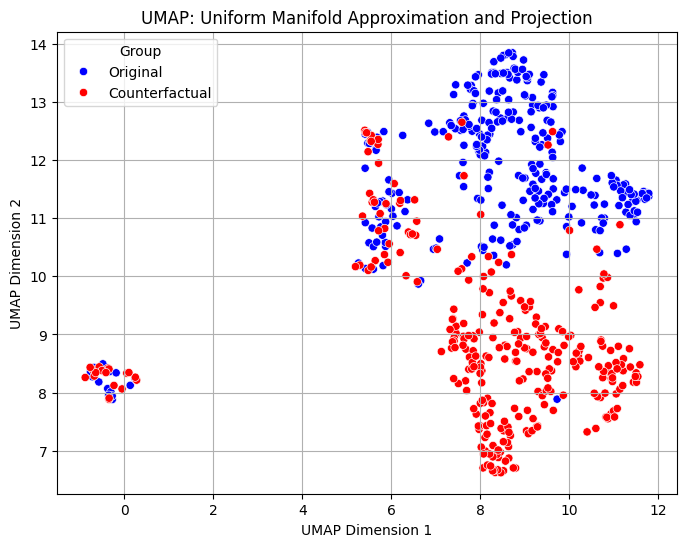

UMAP Quality Metrics:
- k-NN Preservation Rate: 0.3421
Statistical Interpretation:
    The k-NN preservation rate quantifies how well UMAP maintains local neighborhood structures
    from the original high-dimensional space in the 2D projection.



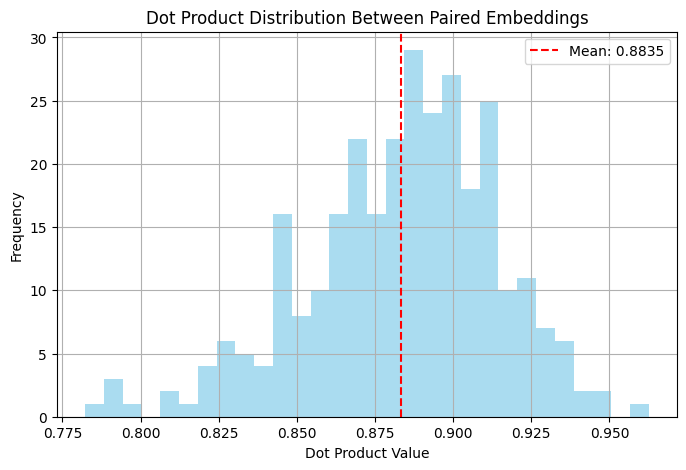

Dot Product Statistics:
- Mean: 0.8835
- Standard Deviation: 0.0306
Statistical Interpretation:
    Dot products measure the alignment between corresponding embedding vectors.
    Higher values indicate greater semantic similarity between paired samples.
    The standard deviation reflects the consistency of similarity across pairs.



In [3]:
!pip install umap-learn
import umap
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.manifold import trustworthiness
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt


def analyze_and_visualize_embeddings(embeddings_a, embeddings_b, labels=('Original', 'Counterfactual')):
    """
    Perform dimensionality reduction and comparative analysis of two sets of embeddings.

    Parameters:
        embeddings_a (np.array): First set of embeddings (n_samples x n_features)
        embeddings_b (np.array): Second set of embeddings (n_samples x n_features)
        labels (tuple): Descriptive labels for the two groups
    """
    combined = np.vstack((embeddings_a, embeddings_b))
    group_labels = [labels[0]] * len(embeddings_a) + [labels[1]] * len(embeddings_b)

    # PCA Dimensionality Reduction
    pca = PCA(n_components=2)
    reduced_pca = pca.fit_transform(combined)

    df_pca = pd.DataFrame({
        'Dim1': reduced_pca[:, 0],
        'Dim2': reduced_pca[:, 1],
        'Group': group_labels
    })

    plt.figure(figsize=(8, 6))
    palette = {labels[0]: 'blue', labels[1]: 'red'}
    sns.scatterplot(data=df_pca, x='Dim1', y='Dim2', hue='Group', palette=palette)
    plt.title("PCA: Principal Component Analysis (2D Projection)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()

    # PCA diagnostic metrics
    explained_var = pca.explained_variance_ratio_
    eigenvalues = pca.explained_variance_
    projected = pca.inverse_transform(reduced_pca)
    reconstruction_error = mean_squared_error(combined, projected)

    print("PCA Diagnostic Metrics:")
    print(f"- Eigenvalues: {eigenvalues}")
    print(f"- Explained Variance Ratio: {explained_var}")
    print(f"- Cumulative Explained Variance: {np.sum(explained_var):.4f}")
    print(f"- Reconstruction MSE: {reconstruction_error:.4f}")
    print("""Statistical Interpretation:
    Eigenvalues indicate the magnitude of variance captured by each principal component.
    Explained variance ratios show the proportion of total variance accounted for by each component.
    Reconstruction error measures information loss during dimensionality reduction.\n""")

    # t-SNE Visualization
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
    reduced_tsne = tsne.fit_transform(combined)

    df_tsne = pd.DataFrame({
        'x': reduced_tsne[:, 0],
        'y': reduced_tsne[:, 1],
        'Group': group_labels
    })

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_tsne, x='x', y='y', hue='Group', palette=palette)
    plt.title("t-SNE: t-distributed Stochastic Neighbor Embedding")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

    # t-SNE quality metrics
    trust = trustworthiness(combined, reduced_tsne, n_neighbors=5)

    # k-NN preservation calculation
    knn_original = NearestNeighbors(n_neighbors=5).fit(combined).kneighbors(return_distance=False)
    knn_embedded = NearestNeighbors(n_neighbors=5).fit(reduced_tsne).kneighbors(return_distance=False)
    preserved = np.mean([
        len(np.intersect1d(knn_original[i], knn_embedded[i])) / 5.0
        for i in range(len(combined))
    ])

    print("t-SNE Quality Metrics:")
    print(f"- KL Divergence: {tsne.kl_divergence_:.4f}")
    print(f"- Trustworthiness: {trust:.4f}")
    print(f"- k-NN Preservation Rate: {preserved:.4f}")
    print("""Statistical Interpretation:
    KL divergence quantifies the difference between high-dimensional and low-dimensional distributions.
    Trustworthiness measures the preservation of neighborhood relationships (higher is better).
    k-NN preservation rate indicates local structure maintenance during dimensionality reduction.\n""")

    # UMAP Projection
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
    reduced_umap = reducer.fit_transform(combined)

    df_umap = pd.DataFrame({
        'x': reduced_umap[:, 0],
        'y': reduced_umap[:, 1],
        'Group': group_labels
    })

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_umap, x='x', y='y', hue='Group', palette=palette)
    plt.title("UMAP: Uniform Manifold Approximation and Projection")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(True)
    plt.show()

    # UMAP quality assessment
    knn_embedded_umap = NearestNeighbors(n_neighbors=5).fit(reduced_umap).kneighbors(return_distance=False)
    preserved_umap = np.mean([
        len(np.intersect1d(knn_original[i], knn_embedded_umap[i])) / 5.0
        for i in range(len(combined))
    ])

    print("UMAP Quality Metrics:")
    print(f"- k-NN Preservation Rate: {preserved_umap:.4f}")
    print("""Statistical Interpretation:
    The k-NN preservation rate quantifies how well UMAP maintains local neighborhood structures
    from the original high-dimensional space in the 2D projection.\n""")

    # Dot Product Analysis
    dot_products = np.sum(embeddings_a * embeddings_b, axis=1)
    mean_dot = np.mean(dot_products)
    std_dot = np.std(dot_products)

    plt.figure(figsize=(8, 5))
    plt.hist(dot_products, bins=30, color='skyblue', alpha=0.7)
    plt.axvline(mean_dot, color='red', linestyle='--', label=f"Mean: {mean_dot:.4f}")
    plt.title("Dot Product Distribution Between Paired Embeddings")
    plt.xlabel("Dot Product Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Dot Product Statistics:")
    print(f"- Mean: {mean_dot:.4f}")
    print(f"- Standard Deviation: {std_dot:.4f}")
    print("""Statistical Interpretation:
    Dot products measure the alignment between corresponding embedding vectors.
    Higher values indicate greater semantic similarity between paired samples.
    The standard deviation reflects the consistency of similarity across pairs.\n""")

# Example execution
analyze_and_visualize_embeddings(embeddings_a, embeddings_b)

### **1.3 Other Comparative Analyses**
 This part integrates centroid distance metrics to assess global vector space shifts, clustering performance to evaluate separability, linguistic statistics for content-level insights, and graph-based visualization to reveal interaction structures in semantic space.

📏 Group Centroid Distance:
- Euclidean Distance-group: 0.1776
- Cosine Distance-group: 0.0190

Euclidean distance reflects spatial divergence between group centers, while cosine distance quantifies semantic angle difference (1 = orthogonal, 0 = identical).

KMeans Clustering:
- Silhouette Score: 0.0645

Silhouette score quantifies cluster quality; values closer to 1 indicate well-separated dense clusters.

Text Feature Analysis:
- Avg. Text Length: 436.81 ± 56.68
- Avg. Type-Token Ratio: 0.5362 ± 0.0478



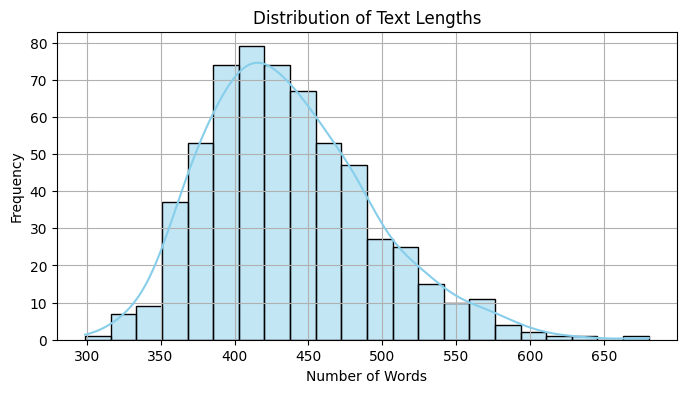

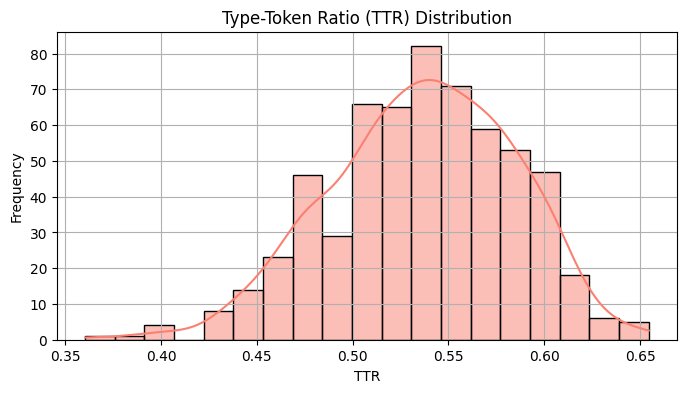

These visualizations reveal lexical variation and verbosity patterns across both groups. TTR indicates vocabulary diversity; higher TTR suggests more unique word usage.



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


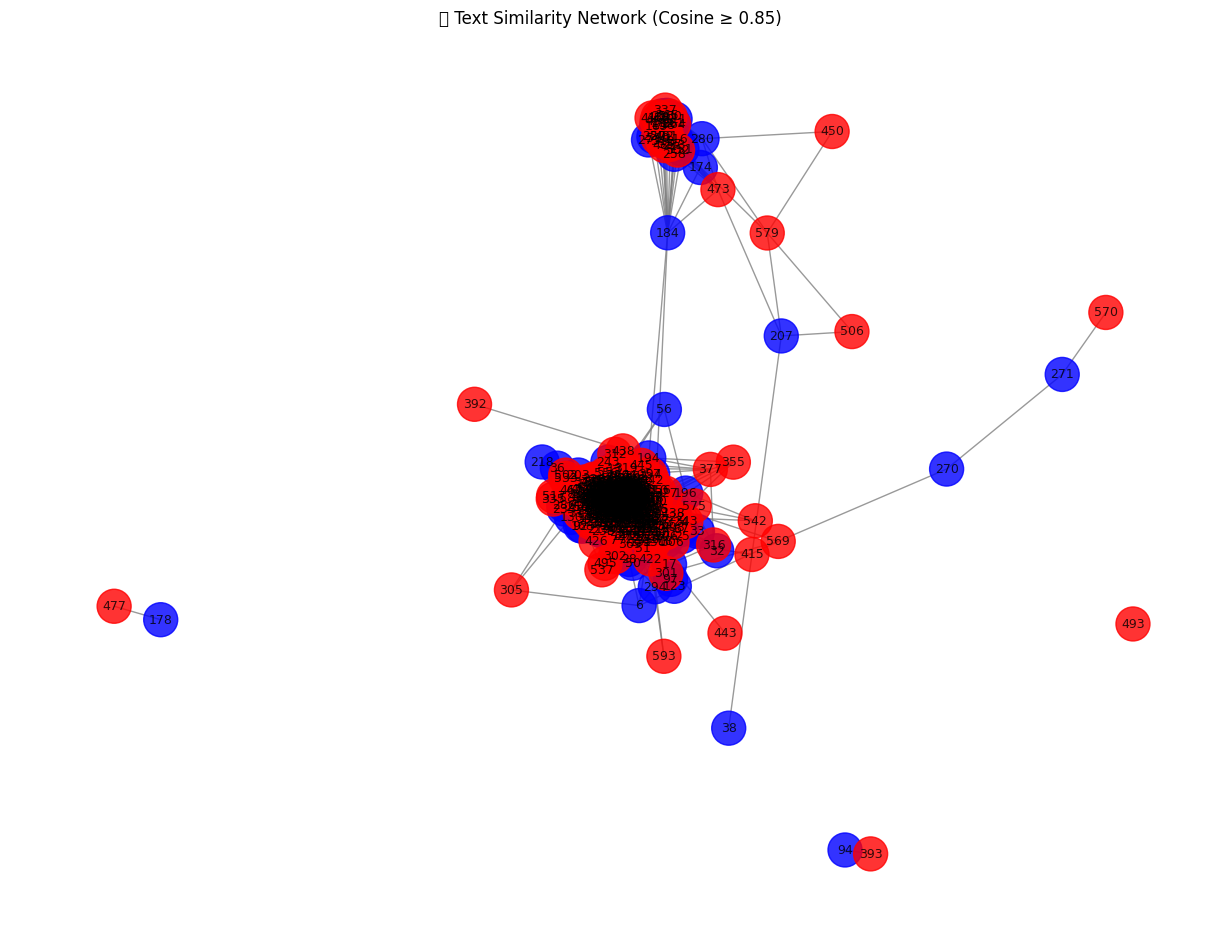

📡 Graph Summary:
- Nodes: 598, Edges: 66454
- Avg. Degree: 222.25, Max Degree: 460
This similarity graph reveals clusters of highly similar texts and the degree of interaction within and across groups. Degree centrality reflects semantic hubness — texts with high degrees are more semantically connected.


In [5]:
# 📦 Import required libraries
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

'''
Assumes the following variables are already loaded:
- embeddings_a, embeddings_b: numpy arrays of shape (n_samples, n_features)
- texts_a, texts_b: lists of strings associated with each embedding
'''

# Group Centroid Distance Analysis

# Compute the mean embedding (centroid) of each group
centroid_a = np.mean(embeddings_a, axis=0)
centroid_b = np.mean(embeddings_b, axis=0)

# Measure distance between group centroids using both Euclidean and cosine metrics
euclidean_distance = np.linalg.norm(centroid_a - centroid_b)
cosine_dist = cosine(centroid_a, centroid_b)

print("📏 Group Centroid Distance:")
print(f"- Euclidean Distance-group: {euclidean_distance:.4f}")
print(f"- Cosine Distance-group: {cosine_dist:.4f}\n")
print("Euclidean distance reflects spatial divergence between group centers, while cosine distance quantifies semantic angle difference (1 = orthogonal, 0 = identical).\n")

'''
Group Centroid Distance complements pairwise similarity analysis by capturing overall semantic drift between groups,
whereas pairwise cosine/Euclidean distances in 1.1 reflect local alignment of text pairs.
'''

# KMeans Clustering and Text Feature Analysis

# Combine embeddings and texts for unified analysis
combined_embeddings = np.vstack((embeddings_a, embeddings_b))
combined_texts = texts_a + texts_b

# Apply KMeans clustering to identify potential separable groups
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(combined_embeddings)
sil_score = silhouette_score(combined_embeddings, cluster_labels)

print("KMeans Clustering:")
print(f"- Silhouette Score: {sil_score:.4f}\n")
print("Silhouette score quantifies cluster quality; values closer to 1 indicate well-separated dense clusters.\n")

# Calculate text-level features: length and type-token ratio (TTR)
lengths = [len(text.split()) for text in combined_texts]
ttrs = [len(set(text.split())) / len(text.split()) if len(text.split()) > 0 else 0 for text in combined_texts]

print("Text Feature Analysis:")
print(f"- Avg. Text Length: {np.mean(lengths):.2f} ± {np.std(lengths):.2f}")
print(f"- Avg. Type-Token Ratio: {np.mean(ttrs):.4f} ± {np.std(ttrs):.4f}\n")

# Plot distribution of text lengths
plt.figure(figsize=(8, 4))
sns.histplot(lengths, kde=True, color='skyblue')
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot distribution of type-token ratios
plt.figure(figsize=(8, 4))
sns.histplot(ttrs, kde=True, color='salmon')
plt.title("Type-Token Ratio (TTR) Distribution")
plt.xlabel("TTR")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print("These visualizations reveal lexical variation and verbosity patterns across both groups. TTR indicates vocabulary diversity; higher TTR suggests more unique word usage.\n")


# Semantic Interaction Network via Cosine Similarity

# Compute cosine similarity matrix for all texts
similarity_matrix = cosine_similarity(combined_embeddings)

# Construct undirected graph: nodes = texts, edges = high-similarity links
G = nx.Graph()
for i in range(len(combined_texts)):
    G.add_node(i, label=i, group='A' if i < len(embeddings_a) else 'B')

# Add edges for text pairs with similarity above a threshold
threshold = 0.85  # similarity cutoff for connection
for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        sim = similarity_matrix[i][j]
        if sim >= threshold:
            G.add_edge(i, j, weight=sim)

# Layout nodes in 2D using spring layout (force-directed)
pos = nx.spring_layout(G, seed=42)
colors = ['blue' if G.nodes[n]['group'] == 'A' else 'red' for n in G.nodes]

# Visualize the similarity network
plt.figure(figsize=(12, 9))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=600, font_size=9, edge_color='gray', alpha=0.8)
plt.title("🔗 Text Similarity Network (Cosine ≥ 0.85)")
plt.show()

# Report network-level statistics
print("📡 Graph Summary:")
print(f"- Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
degree_dist = [d for _, d in G.degree()]
print(f"- Avg. Degree: {np.mean(degree_dist):.2f}, Max Degree: {np.max(degree_dist)}")

print("This similarity graph reveals clusters of highly similar texts and the degree of interaction within and across groups. Degree centrality reflects semantic hubness — texts with high degrees are more semantically connected.")


# **2.Analysis of scores' value to essays.**

Extract score from responses.
Group A contains scores for original essays and Group B contains those for counterfactual essays.

In [6]:
import pandas as pd
import re

# extract score from responses
def extract_score(text):
    patterns = [
        r'\*\*(\d[\d.]*)\*\*',  # **4** or **4.5**
        r'Score:\s*([\d.]+)',    # "Score: 3" or "Score: 4.5"
        r'^(\d[\d.]*)\s*$',      #  "3" or "4.5"
        r'(\d[\d.]*)\s*out of 5',#  "4 out of 5"
        r'(\d[\d.]*)/5',         #  "4/5"
        r'^(\d[\d.]*)\s*[-:]',   #  "4 -" or "4:"
        r'\b(\d[\d.]*)\s*$'      # Match the fraction at the end of the line
    ]
    if not isinstance(text, str):
        return None
    first_line = text.split('\n')[0].strip()
    if re.match(r'^\d[\d.]*$', first_line):
        return float(first_line)
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE | re.MULTILINE)
        if match:
            try:
                score = float(match.group(1))
                if 0 <= score <= 5:
                    return score
            except ValueError:
                continue
    return None

def extract_scores_no_header(input_path, output_path):
    df = pd.read_excel(input_path, header=None)
    df.columns = ['group a', 'group b']

    df['group a score'] = df['group a'].apply(extract_score)
    df['group b score'] = df['group b'].apply(extract_score)

    score_df = df[['group a score', 'group b score']]
    score_df.to_excel(output_path, index=False)
    print("Score extraction is complete and has been saved as:", output_path)

extract_scores_no_header(
    input_path='/content/cosine similarity calculationM vs M-F.xlsx',
    output_path='/content/extracted_scores_only.xlsx'
)

Score extraction is complete and has been saved as: /content/extracted_scores_only.xlsx


Descriptive Statistics:
       group a score  group b score
count     300.000000     300.000000
mean        3.226667       3.232667
std         0.473677       0.480036
min         2.000000       2.000000
25%         3.000000       3.000000
50%         3.000000       3.000000
75%         3.500000       3.500000
max         4.000000       4.000000

🧪 Paired t-test:
t = -0.2240, p = 0.8229
→ no significant difference


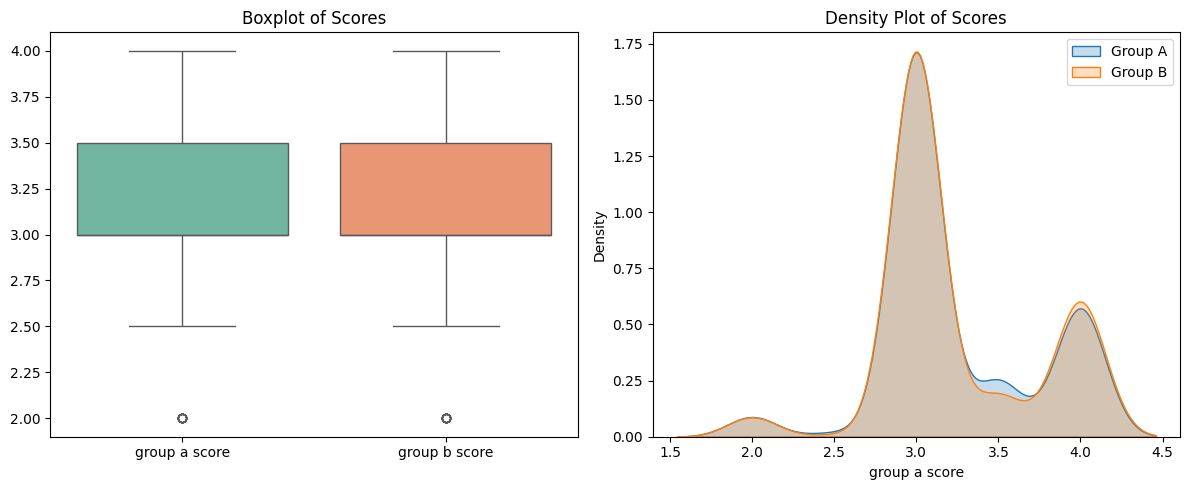

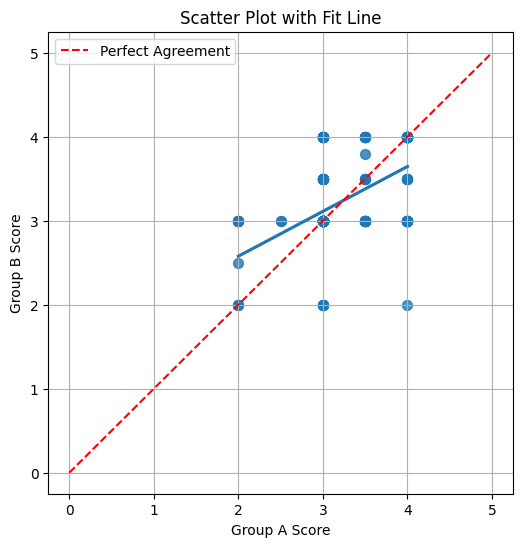

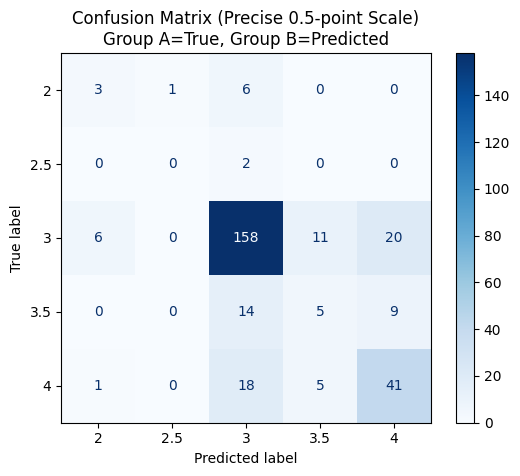


Categorized reports (Taking Group A as real labels, Group B for predicted labels):
              precision    recall  f1-score   support

           2       0.30      0.30      0.30        10
         2.5       0.00      0.00      0.00         2
           3       0.80      0.81      0.80       195
         3.5       0.24      0.18      0.20        28
           4       0.59      0.63      0.61        65

    accuracy                           0.69       300
   macro avg       0.38      0.38      0.38       300
weighted avg       0.68      0.69      0.68       300


Cohen’s Kappa Score (0.5-point scale): 0.395
→ Consistency level: Less consistency


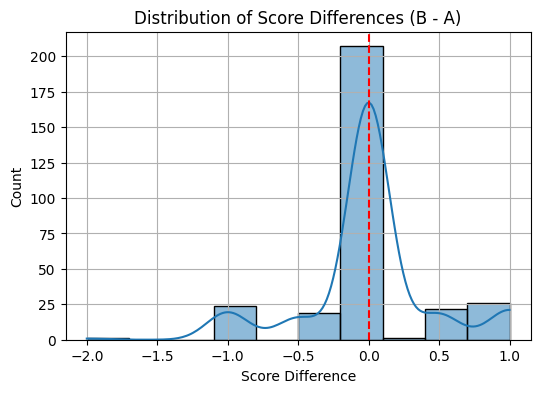


Analysis of variances by specific scores:
When Group A is 2.0（n=10）:
  → Group B average difference: 0.650
  → Group B scoring distribution: {2.0: 3, 2.5: 1, 3.0: 6}
When Group A is 2.5（n=2）:
  → Group B average difference: 0.500
  → Group B scoring distribution: {3.0: 2}
When Group A is 3.0（n=195）:
  → Group B average difference: 0.100
  → Group B scoring distribution: {2.0: 6, 3.0: 158, 3.5: 11, 4.0: 20}
When Group A is 3.5（n=28）:
  → Group B average difference: -0.096
  → Group B scoring distribution: {3.0: 14, 3.5: 5, 3.8: 1, 4.0: 8}
When Group A is 4.0（n=65）:
  → Group B average difference: -0.346
  → Group B scoring distribution: {2.0: 1, 3.0: 18, 3.5: 5, 4.0: 41}


<ipython-input-7-49f9454c440d>:114: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset['score_diff'], label=f'A={score}', fill=True)


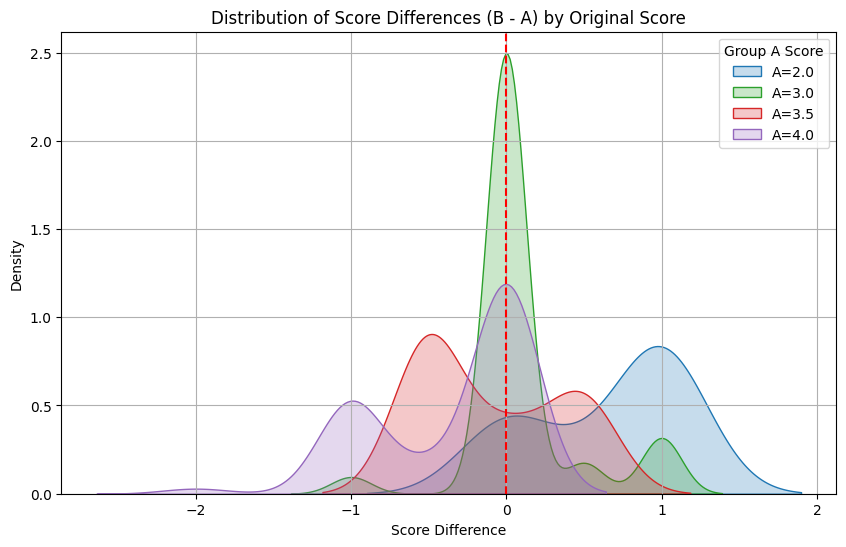

<ipython-input-7-49f9454c440d>:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=direction_counts.index, y=direction_counts.values, palette="viridis")



Statistics on the direction of change in scores:
direction
No change    207
Increase      49
Decrease      44
Name: count, dtype: int64


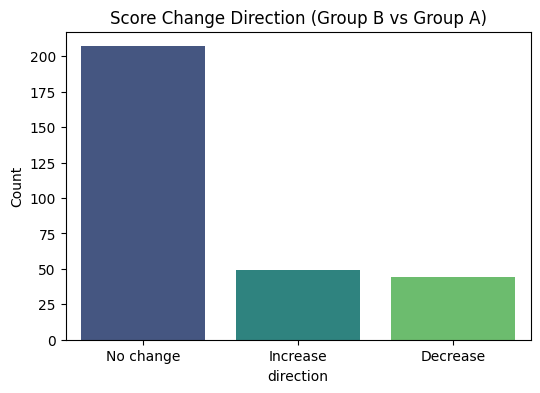


Difference in average ratings（Group B - Group A）: 0.006


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

df = pd.read_excel("/content/extracted_scores_only.xlsx")
a_scores = df['group a score']
b_scores = df['group b score']

# Descriptive Statistics
print("Descriptive Statistics:")
print(df.describe())

# 2️Paired t-test
t_stat, p_val = ttest_rel(a_scores, b_scores)
print(f"\n🧪 Paired t-test:\nt = {t_stat:.4f}, p = {p_val:.4f}")
if p_val < 0.05:
    print("→ significant difference")
else:
    print("→ no significant difference")

#Box Plot + Density Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, palette="Set2")
plt.title("Boxplot of Scores")
plt.subplot(1, 2, 2)
sns.kdeplot(a_scores, label='Group A', fill=True)
sns.kdeplot(b_scores, label='Group B', fill=True)
plt.title("Density Plot of Scores")
plt.legend()
plt.tight_layout()
plt.show()

#Scatterplot + Line of Fit
plt.figure(figsize=(6, 6))
sns.regplot(x=a_scores, y=b_scores, ci=None, scatter_kws={"s": 50})
plt.plot([0, 5], [0, 5], 'r--', label="Perfect Agreement")
plt.xlabel("Group A Score")
plt.ylabel("Group B Score")
plt.title("Scatter Plot with Fit Line")
plt.legend()
plt.grid(True)
plt.show()

#Confusion matrix
'''
a_int = a_scores.round().astype(int)
b_int = b_scores.round().astype(int)
conf_mat = confusion_matrix(a_int, b_int, labels=[1,2,3,4,5])
disp = ConfusionMatrixDisplay(conf_mat, display_labels=[1,2,3,4,5])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Rounded Scores)")
plt.grid(False)
plt.show()
'''
bins = [1.9, 2.25, 2.75, 3.25, 3.75, 4.25]  # Define split-box boundaries, could be set according to the actual scoring interval
labels = ['2', '2.5', '3', '3.5', '4']

a_cat = pd.cut(a_scores, bins=bins, labels=labels, right=False)
b_cat = pd.cut(b_scores, bins=bins, labels=labels, right=False)

conf_mat = confusion_matrix(a_cat, b_cat, labels=labels)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Precise 0.5-point Scale)\nGroup A=True, Group B=Predicted")
plt.grid(False)
plt.show()
# 计算分类报告
from sklearn.metrics import classification_report
print("\nCategorized reports (Taking Group A as real labels, Group B for predicted labels):")
print(classification_report(a_cat, b_cat, target_names=labels, zero_division=0))

# Cohen's Kappa Score
kappa = cohen_kappa_score(a_cat, b_cat)
print(f"\nCohen’s Kappa Score (0.5-point scale): {kappa:.3f}")
if kappa < 0.2:
    level = "Almost no consistency"
elif kappa < 0.4:
    level = "Less consistency"
elif kappa < 0.6:
    level = "Medium consistency"
elif kappa < 0.8:
    level = "Good consistency"
else:
    level = "Almost perfect consistency"
print(f"→ Consistency level: {level}")

# score difference
df['score_diff'] = b_scores - a_scores
plt.figure(figsize=(6, 4))
sns.histplot(df['score_diff'], bins=10, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Score Differences (B - A)")
plt.xlabel("Score Difference")
plt.grid(True)
plt.show()

print("\nAnalysis of variances by specific scores:")
score_levels = sorted(df['group a score'].unique())
for score in score_levels:
    subset = df[df['group a score'] == score]
    mean_diff = subset['score_diff'].mean()
    count = len(subset)
    print(f"When Group A is {score:.1f}（n={count}）:")
    print(f"  → Group B average difference: {mean_diff:.3f}")
    print(f"  → Group B scoring distribution: {subset['group b score'].value_counts().sort_index().to_dict()}")

plt.figure(figsize=(10, 6))
for score in sorted(df['group a score'].unique()):
    subset = df[df['group a score'] == score]
    sns.kdeplot(subset['score_diff'], label=f'A={score}', fill=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Score Differences (B - A) by Original Score")
plt.xlabel("Score Difference")
plt.legend(title="Group A Score")
plt.grid(True)
plt.show()

#Statistics on the direction of change in scores
df['direction'] = np.where(df['score_diff'] > 0, 'Increase',
                          np.where(df['score_diff'] < 0, 'Decrease', 'No change'))
direction_counts = df['direction'].value_counts()
print("\nStatistics on the direction of change in scores:")
print(direction_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=direction_counts.index, y=direction_counts.values, palette="viridis")
plt.title("Score Change Direction (Group B vs Group A)")
plt.ylabel("Count")
plt.show()

mean_diff = df['score_diff'].mean()
print(f"\nDifference in average ratings（Group B - Group A）: {mean_diff:.3f}")